In [9]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import joblib

In [10]:
try:
    df = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/accesos_biblioteca.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'accesos_biblioteca.csv'.")
    exit(1)

Dataset cargado desde 'Datasets/accesos_biblioteca.csv'


In [11]:
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df


In [12]:
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)
    
def obtener_semana_semestre(fecha):
    mes = fecha.month
    dia = fecha.day
    if 3 <= mes <= 7:
        inicio_semestre = datetime(fecha.year, 3, 1)
    elif 8 <= mes <= 12:
        inicio_semestre = datetime(fecha.year, 8, 1)
    else:
        return 0  # Fuera de semestre
    delta = fecha - inicio_semestre
    semana_semestre = delta.days // 7 + 1
    return semana_semestre

In [13]:
for col in ['Accesos']:
    df[col] = df[col].fillna(0).astype(int)

df = df[
    pd.to_datetime(df['Fecha']).dt.weekday != 6
].reset_index(drop=True)

df = agregar_medias_moviles(df, 'Accesos', [7, 14, 30])
df = agregar_variables_ciclicas(df, 'Mes', 'Fecha')
df = agregar_ewma(df, 'Accesos', [7, 14, 30])

df['Semestre'] = df['Mes'].apply(obtener_semestre)
df['Semana_Semestre'] = pd.to_datetime(df['Fecha']).apply(obtener_semana_semestre)

df['Fecha'] = pd.to_datetime(df['Fecha'])

df = agregar_lags(df, 'Accesos', [7, 14, 21])

df = df.dropna().reset_index(drop=True)
df.tail(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,...,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre,lag_7,lag_14,lag_21
412,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,...,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866,9,2544.0,4145.0,3923.0
413,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,...,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520,10,1356.0,1592.0,4248.0
414,2025-05-05,5,5,2025,1,2750,0,1028.428571,1531.857143,2438.466667,...,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938,10,526.0,0.0,3976.0
415,2025-05-06,6,5,2025,1,1866,0,1346.142857,1728.285714,2417.700000,...,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296,10,2400.0,0.0,3140.0
416,2025-05-07,7,5,2025,1,2254,0,1269.857143,1861.571429,2362.766667,...,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697,10,2568.0,3841.0,852.0


In [14]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"\n")
print(f"Preparación de Datos Finalizada")
print(f"Datos de entrenamiento: {len(y_train)} | Datos de prueba: {len(y_test)}")



Preparación de Datos Finalizada
Datos de entrenamiento: 333 | Datos de prueba: 84


In [15]:
# Entrenamiento y Evaluación con LightGBM
# Configuración de búsqueda de hiperparámetros
os.makedirs('Archivos Auxiliares', exist_ok=True)
if "modelo_LightGBM.pkl" not in os.listdir('Archivos Auxiliares'):
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'learning_rate': [0.01, 0.03],
        'n_estimators': [200, 500],
        'num_leaves': [31, 50],
        # opcional (incluye solo si sospechas overfit)
        'subsample': [0.8, 1.0]
    }


    print("\nIniciando entrenamiento y ajuste de hiperparámetros de LightGBM...")

    # 1. Búsqueda de Hyperparámetros
    grid_search = GridSearchCV(
        lgb.LGBMRegressor(random_state=42, n_jobs=-1, objective='regression'),
        param_grid,  # Usando el conjunto de parámetros mejorado
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=2 # Aumentamos el verbose para seguir mejor el progreso
    )

    grid_search.fit(X_train, y_train)

    print(f'Mejores parámetros para LightGBM: {grid_search.best_params_}')

    # 2. Entrenamiento del modelo final con los mejores parámetros
    best_params = grid_search.best_params_
    model = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1, objective='regression')
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares/modelo_LightGBM.pkl')
    print("Modelo LightGBM guardado como 'Archivos Auxiliares/modelo_LightGBM.pkl'")
# Guardar el modelo
else:
    model = joblib.load('Archivos Auxiliares/modelo_LightGBM.pkl')
    print("Modelo LightGBM cargado desde 'Archivos Auxiliares/modelo_LightGBM.pkl'")

Modelo LightGBM cargado desde 'Archivos Auxiliares/modelo_LightGBM.pkl'


In [18]:
# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
print("\n=== IMPORTANCIA DE LAS CARACTERÍSTICAS ===\n")
for i, idx in enumerate(indices):
    if idx < len(X.columns):
        print(f"{i + 1:2d}. {X.columns[idx]}: {importancias[idx]:.4f}")


=== IMPORTANCIA DE LAS CARACTERÍSTICAS ===

 1. dia_semana_cos: 449.0000
 2. media_movil_14: 298.0000
 3. Año: 198.0000
 4. mes_sin: 156.0000
 5. mes_cos: 154.0000
 6. Vacaciones?: 139.0000
 7. Semestre: 124.0000
 8. media_movil_30: 97.0000
 9. ewma_14: 57.0000
10. dia_semana_sin: 57.0000
11. media_movil_7: 50.0000
12. Mes: 30.0000
13. ewma_7: 19.0000
14. Día: 0.0000


In [20]:
# Eliminar características con importancia menor a 0.01
umbral_importancia = 0.01

# Solo considera las columnas usadas por el modelo
columnas_modelo = X.columns[:len(importancias)]
FEATURES = columnas_modelo[importancias >= umbral_importancia]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

# Reentrenar el modelo con las características seleccionadas
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 333, number of used features: 13
[LightGBM] [Info] Start training from score 1306.288288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.01
,n_estimators,200
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [21]:
# Evaluación de rendimiento
predicted = model.predict(X_test)
predicted = np.maximum(predicted, 0)


--- Evaluación de rendimiento de LightGBM en el set de prueba ---
R²: 0.87
Error Cuadrático Medio (MSE): 299607.52
Error Cuadrático Medio Raíz (RMSE): 547.36
Error Absoluto Medio (MAE): 424.33

Se han generado las siguientes visualizaciones:
- lightgbm_predicciones.png (Comparación de valores reales vs. predichos)
- lightgbm_importancia.png (Importancia de las variables)


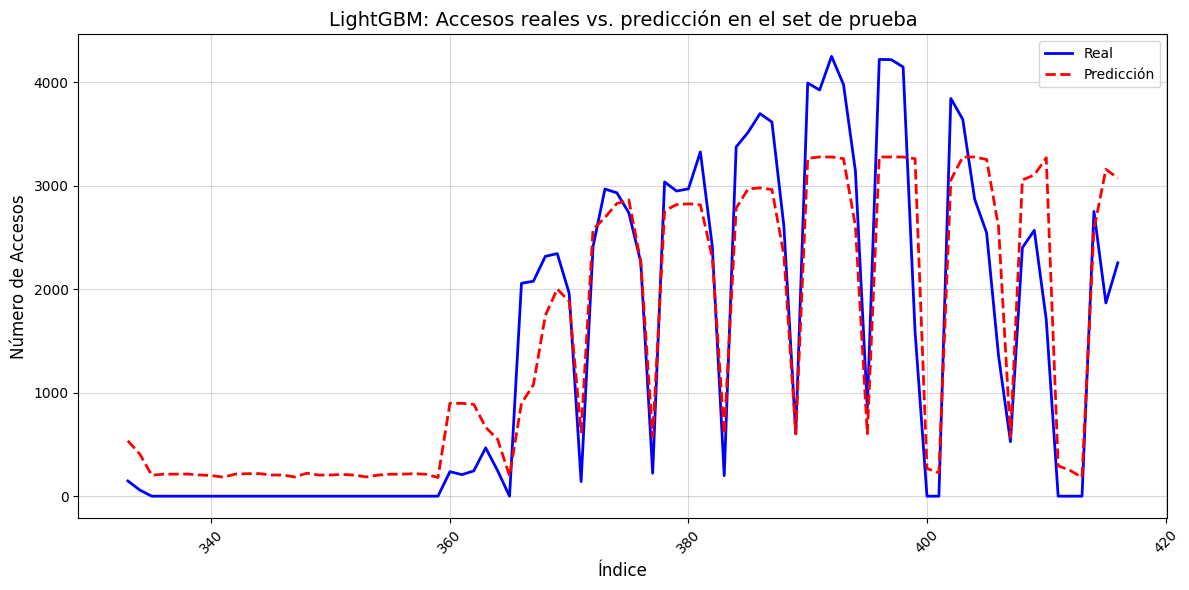

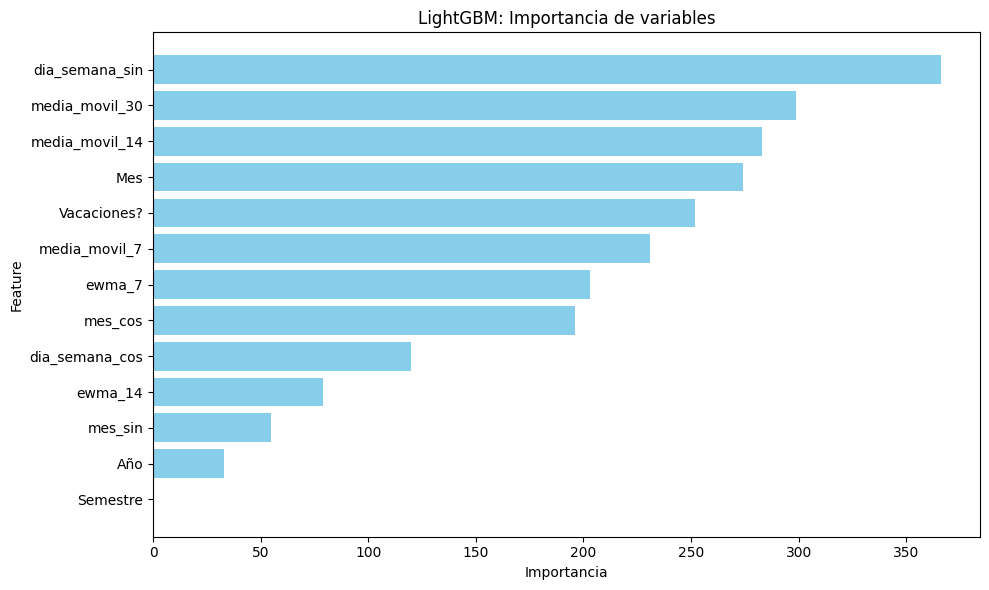

In [ ]:
# Cálculo de métricas
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print("\n--- Evaluación de rendimiento de LightGBM en el set de prueba ---")
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

# Graficar resultados de la predicción (Real vs. Predicción en el test set)
results_df = pd.DataFrame({
    'Índice': X_test.index,
    'Real': y_test,
    'Predicción': predicted
}).sort_values(by='Índice')

plt.figure(figsize=(12, 6))
plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='red', linestyle='--', linewidth=2)
plt.title('LightGBM: Accesos reales vs. predicción en el set de prueba', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('lightgbm_predicciones.png')

# Graficar importancia de variables
importances = model.feature_importances_
importance_df = pd.DataFrame({"Feature": FEATURES, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("LightGBM: Importancia de variables")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('lightgbm_importancia.png')

print("\nSe han generado las siguientes visualizaciones:")
print("- lightgbm_predicciones.png (Comparación de valores reales vs. predichos)")
print("- lightgbm_importancia.png (Importancia de las variables)")